<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/2_Variational_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from scipy.special import digamma, polygamma, loggamma

# **1. Preprocessing**

## **1-1. Load data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data path

train_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/train.txt"
test_path = "/content/drive/MyDrive/ML_lab/2_LDA/data/pos_tag/test.txt"

In [4]:
def read_file(path):
  raw = open(path, 'r').read().split('\n') # 파일을 읽어와 줄마다 나누기
  data, doc = list(), list()

  for i, line in enumerate(raw):
    if line.strip(): # 빈 줄이 아니면
      word = line.split(' ')[0].lower() # 첫 번째 단어를 얻어온 후 소문자로 변환
      doc.append(word)
    else:
      data.append(doc) # EOD(End Of Document)
      doc = list()
  data.append(doc) # 맨 마지막 문서 추가

  return data

In [5]:
# 데이터 불러오기
train_data = read_file(train_path)
test_data = read_file(test_path)

# 맨 마지막 문서는 제거
del train_data[-1], test_data[-1]

## **1-2. Preprocess Data**

In [6]:
# some words that we do not want to consider
stopwords = [""," "]

In [7]:
## remove numbers, special characters, etc.
# only consider words with alphabet

def only_alphabet(corpus, stopword_list=stopwords):
    pattern = re.compile('[^a-z]')
    # non-alphabet 문자 제거(=> 정규표현식 활용)
    return [
        [pattern.sub('', word) for word in doc if pattern.sub('', word) not in stopword_list] for doc in corpus
    ]

In [8]:
train_data = only_alphabet(train_data)
test_data = only_alphabet(test_data)

In [9]:
## count word occurrence in corpus

def count_vocab(corpus):
  vocab = defaultdict(int) # dictionary 형태로 word occurence를 기록
  for doc in corpus:
    for word in doc:
      vocab[word] += 1

  return vocab

In [10]:
vocab_count = count_vocab(train_data)

In [11]:
## 특정 빈도수 이상인 단어들만 고려
# sparse한 단어는 무시

def vocab_top(vocab,cnt):
  return {voca: count for voca, count in vocab.items() if count > cnt}

In [12]:
vocab_count = vocab_top(vocab_count,cnt = 5)

In [13]:
## filter out low-occurrence words

def filter_vocab(corpus, vocab):
    vocab_set = set(vocab)
    return [
        [word for word in doc if word in vocab_set] for doc in corpus
    ]

In [14]:
train_data = filter_vocab(train_data,vocab_count)
test_data = filter_vocab(test_data,vocab_count)

In [15]:
## construct voca-index-matching dictionary

def voca_index(vocab):
  vocab_to_index = {voca: i for i, voca in enumerate(vocab.keys())}
  index_to_vocab = {i: voca for i, voca in enumerate(vocab.keys())}

  return vocab_to_index, index_to_vocab

In [16]:
v_t_i, i_t_v = voca_index(vocab_count)

In [17]:
## convert corpus-with-words to corpus-with-index

def corpus_to_index(corpus,vocab_to_index):
  return [[vocab_to_index[word] for word in doc] for doc in corpus]

In [18]:
train_data_idx = corpus_to_index(train_data,v_t_i)
test_data_idx = corpus_to_index(test_data,v_t_i)

# **2. Modeling**

In [19]:
class LDA_VI:
  def __init__(self,docs, num_topic=10, vocab = None, alpha=1.,num_iter=100,lr=1e-3):
    self.docs = docs
    self.num_topic = num_topic
    self.vocab = vocab
    self.num_vocab = len(self.vocab)
    self.num_docs = len(self.docs)

    # Initialize alpha and beta
    self.alpha = np.ones(self.num_topic)*(1/self.num_topic)
    self.beta = np.ones((self.num_topic, self.num_vocab))*(1/self.num_vocab)
    # beta 초기값 업데이트
    self.beta += np.random.rand(self.num_topic, self.num_vocab) * 0.01
    self.beta /= np.sum(self.beta, axis=1)[:, np.newaxis]

    # Initialize gamma and phi
    self.gamma = np.ones((self.num_docs,self.num_topic))*(1/self.num_topic)
    self.phi = np.ones((self.num_docs, self.num_vocab, self.num_topic))*(1/self.num_topic) # <- 수정

    # Initialize z (topic assignments for words in documents)
    self.z = [[np.random.randint(0, self.num_topic) for _ in range(len(doc))] for doc in self.docs]

    # Initialize parameters for variational inference
    self.num_iter = num_iter
    self.lr = lr

    self.elbo_list = []  # ELBO 값을 저장할 리스트
    self.perp_list = []  # perplexity 값을 저장할 리스트

  def update_gamma(self):
    ## Update gamma (document-topic distributions)
    self.gamma = self.alpha + np.sum(self.phi, axis = 1)

  def update_phi(self):
    ## Update phi (topic-word distributions)
    for d in range(self.num_docs):
      for n in range(len(self.docs[d])):
        word_idx = self.docs[d][n]
        self.phi[d, n] = self.beta[:, word_idx] * np.exp(digamma(self.gamma[d]))
    # phi 정규화(topic에 대해 정규화)
    self.phi /= np.sum(self.phi, axis = 2)[:, :, np.newaxis]

  def update_beta(self):
    ## Update beta(topic-word prior)
    for d in range(self.num_docs):
      for n in range(len(self.docs[d])):
        word_idx = self.docs[d][n]
        self.beta[:, word_idx] += self.phi[d, n]
    # beta 정규화(word에 대해 정규화)
    self.beta /= np.sum(self.beta, axis = 1)[:, np.newaxis]

  def update_alpha(self):
    ## Update alpha(document-topic prior)
    M = self.num_docs
    g = np.zeros(self.num_topic) # gradient
    H = np.zeros((self.num_topic, self.num_topic)) # Hessian matrix

    for i in range(self.num_topic):
      g[i] = M * ( digamma(np.sum(self.alpha)) - digamma(self.alpha[i]) )
      for d in range(M):
        g[i] += ( digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])) )
      for j in range(self.num_topic):
        H[i, j] = 0
        if i == j:
          H[i, j] -= M * polygamma(1, self.alpha[i])
        H[i, j] += M * (polygamma(1, np.sum(self.alpha)))

    # alpha 업데이트(=> Newton-Raphson)
    deltaAlpha = np.dot(np.linalg.inv(H), g)
    self.alpha -= deltaAlpha

  def e_step(self):
    ## Perform E-step of the variational inference
    self.update_phi()
    self.update_gamma()

  def m_step(self):
    ## Perform M-step of the variational inference
    self.update_beta()
    self.update_alpha()

  def compute_elbo(self):
    ## Compute Evidence Lower Bound (ELBO)

    # 필요한 파라미터 정의
    elbo = 0
    M = self.num_docs
    k = self.num_topic

    # 1번 수식
    for d in range(M): # document
      for n in range(len(self.docs[d])):
        j = self.docs[d][n] # word idx
        for i in range(k): # topic
          elbo += self.phi[d, n, i] * np.log(self.beta[i, j])

    # 2번 수식
    for d in range(M):
      for n in range(len(self.docs[d])):
        for i in range(k):
          elbo += self.phi[d, n, i] * (digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])))

    # 3번 수식
    for d in range(M):
      elbo += loggamma(np.sum(self.alpha))
      for i in range(k):
        elbo -= loggamma(self.alpha[i])
        elbo += (self.alpha[i] - 1) * (digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])))

    # 4번, 5번 수식
    for d in range(M):
      elbo -= loggamma(np.sum(self.gamma[d]))
      for i in range(k):
        elbo += loggamma(np.sum(self.gamma[d, i]))
        elbo -= (self.gamma[d, i] - 1)*( digamma(self.gamma[d, i]) - digamma(np.sum(self.gamma[d])) )
        for n in range(len(self.docs[d])):
          elbo -= self.phi[d, n, i] * np.log(self.phi[d, n, i])

    return elbo

  def compute_perplexity(self, elbo):
    # 분모
    N = sum(len(doc) for doc in self.docs)

    perplexity = np.exp(-elbo / N)
    return perplexity

  def run(self):
    start_time = time.time()

    ## Run the variational inference algorithm
    for iter in range(self.num_iter):
      print(f"=== Iteration: {iter + 1} ===")
      print(f"start time: {round(time.time() - start_time, 2)}")
      self.e_step()
      self.m_step()

      elbo = self.compute_elbo()
      print(f"ELBO: {elbo}")
      self.elbo_list.append(elbo)

      perplexity = self.compute_perplexity(elbo)
      print(f"Perplexity: {perplexity}")
      self.perp_list.append(perplexity)

      print()

    print("EM Algorithm 끝!")

  def plot_result(self):
    plt.figure(figsize = (12, 6))

    # ELBO 시각화
    plt.subplot(1, 2, 1)
    plt.plot(self.elbo_list, color = 'blue')
    plt.title('ELBO')
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.grid(True)

    # perplexity 시각화
    plt.subplot(1, 2, 2)
    plt.plot(self.perp_list, color='orange')
    plt.title('Perplexity')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# **3. Run!!**

In [20]:
model = LDA_VI(train_data_idx,num_topic = 10, vocab = v_t_i, alpha = 1.,num_iter = 100,lr = 1e-3)
model.run()

=== Iteration: 1 ===
start time: 0.0
ELBO: -1304804.0388879636
Perplexity: 3918.1950366249735

=== Iteration: 2 ===
start time: 33.28
ELBO: -1268366.7071407665
Perplexity: 3109.9059303243594

=== Iteration: 3 ===
start time: 57.07
ELBO: -1236017.37036901
Perplexity: 2533.1780396065947

=== Iteration: 4 ===
start time: 81.8
ELBO: -1206306.0878667887
Perplexity: 2098.208691754659

=== Iteration: 5 ===
start time: 107.81
ELBO: -1178016.71310898
Perplexity: 1753.667315753393

=== Iteration: 6 ===
start time: 132.3
ELBO: -1150460.791269422
Perplexity: 1472.5344696717673

=== Iteration: 7 ===
start time: 155.86
ELBO: -1123535.0767416277
Perplexity: 1241.4211960479824

=== Iteration: 8 ===
start time: 180.59
ELBO: -1097585.6641701998
Perplexity: 1053.0798934026955

=== Iteration: 9 ===
start time: 205.54
ELBO: -1073382.564878196
Perplexity: 903.2591535158773

=== Iteration: 10 ===
start time: 229.54
ELBO: -1052166.3621683237
Perplexity: 789.566196988586

=== Iteration: 11 ===
start time: 253.

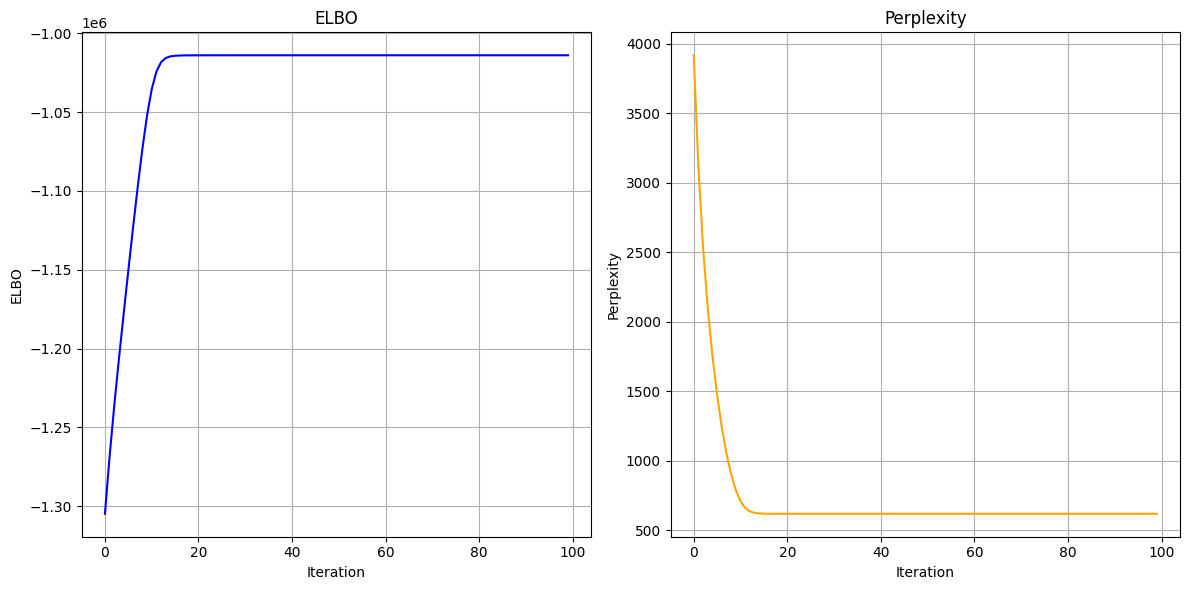

In [21]:
## 학습 과정 시각화

model.plot_result()

# **4. Inference**

In [22]:
## analyze each doc's topic proportion

for d, gamma in enumerate(model.gamma):
  print(f"Document {d} topic distribution: {gamma / np.sum(gamma)}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 0.09999961 0.09999986 0.0999998  0.1000003 ]
Document 6433 topic distribution: [0.10000036 0.09999925 0.09999974 0.09999965 0.09999923 0.09999969
 0.09999951 0.10000069 0.10000065 0.10000124]
Document 6434 topic distribution: [0.10000022 0.10000018 0.09999966 0.09999919 0.09999986 0.09999973
 0.09999989 0.10000134 0.09999991 0.10000002]
Document 6435 topic distribution: [0.09999908 0.09999998 0.09999951 0.09999991 0.10000017 0.09999941
 0.10000019 0.10000125 0.10000034 0.10000016]
Document 6436 topic distribution: [0.10000181 0.09999995 0.09999858 0.10000007 0.0999994  0.10000094
 0.09999915 0.09999973 0.09999991 0.10000045]
Document 6437 topic distribution: [0.1        0.10000113 0.09999878 0.10000012 0.10000109 0.09999975
 0.1000009  0.09999988 0.09999919 0.09999916]
Document 6438 topic distribution: [0.1000013  0.10000016 0.10000089 0.09999961 0.09999885 0.09999943
 0.09999912 0.09999941 0.10000107 0.10000017]
Document 6439 topic distribution: [0

In [23]:
## analyze topic-word proportion

for k, beta in enumerate(model.beta):
  top_words = np.argsort(beta)[-10:]
  print(f"Topic {k} top words: {[i_t_v[i] for i in top_words]}")

Topic 0 top words: ['said', 'million', 'on', 's', 'and', 'of', 'to', 'in', 'a', 'the']
Topic 1 top words: ['said', 'for', 'it', 'and', 'in', 'that', 'of', 'to', 'a', 'the']
Topic 2 top words: ['at', 'and', 'said', 'that', 'it', 'in', 'is', 'a', 'of', 'to']
Topic 3 top words: ['was', 'at', 'it', 'to', 's', 'and', 'for', 'a', 'the', 'of']
Topic 4 top words: ['for', 'said', 'mr', 'million', 'and', 'that', 'of', 'in', 'to', 'the']
Topic 5 top words: ['on', 'mr', 'the', 's', 'that', 'for', 'and', 'to', 'in', 'of']
Topic 6 top words: ['and', 'at', 'by', 'million', 'for', 'to', 'of', 'in', 'a', 'the']
Topic 7 top words: ['on', 'a', 'that', 'is', 'of', 'the', 'to', 's', 'and', 'in']
Topic 8 top words: ['said', 'as', 'for', 'on', 's', 'a', 'to', 'the', 'of', 'and']
Topic 9 top words: ['from', 'for', 'is', 'that', 'to', 'and', 'in', 'of', 'a', 'the']
